# Breast Cancer Image Classifier

In this project I will train an image classifier of breast ultrasound (US) images to predict if the tissue is normal, or if there is a benign or malignant tumor. I will use the **Breast Ultrasound Images Dataset** (https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset/), that includes breast ultrasound images categorized into normal, benign and malignant classes. The dataset is downloaded into `./data/full`.

In [1]:
import os
import numpy as np
import pandas as pd
import dask.bag as db
import random
import splitfolders
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

2024-12-09 19:14:18.579831: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 19:14:18.586909: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 19:14:18.607066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733768058.641334   73955 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733768058.650897   73955 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 19:14:18.686785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Exploratory Data Analysis

Medical image datasets typically include mask images&mdash;binary or multi-class images that indicate which pixels in the original image correspond to a specific region or structure&mdash;for segmentation, i.e. the process of delimiting regions of interest, such as tumors, in an image.

In [2]:
!echo "Number of ultrasound images in class 'benign': $(ls ./data/full/benign/ | grep -v "mask" | wc -l)"
!echo "Number of masks in class 'benign': $(ls ./data/full/benign/ | grep "mask" | wc -l)"
!echo "Number of ultrasound images in class 'malignant': $(ls ./data/full/malignant/ | grep -v "mask" | wc -l)"
!echo "Number of masks in class 'malignant': $(ls ./data/full/malignant/ | grep "mask" | wc -l)"
!echo "Number of ultrasound images in class 'normal': $(ls ./data/full/normal/ | grep -v "mask" | wc -l)"
!echo "Number of masks in class 'normal': $(ls ./data/full/normal/ | grep "mask" | wc -l)"

Number of ultrasound images in class 'benign': 437
Number of masks in class 'benign': 454
Number of ultrasound images in class 'malignant': 210
Number of masks in class 'malignant': 211
Number of ultrasound images in class 'normal': 133
Number of masks in class 'normal': 133


In our dataset, the number of ultrasound and mask images do not match for the 'benign' and 'malignant' classes. Let's check if all ultrasound images have an associated mask image:

In [3]:
!echo "Images of the class 'benign' which have none or more than one associated mask:"
!ls ./data/full/benign/ | awk -F'[._]' '{print $1}' | sort | uniq -c | awk '{if ($1 != 2) { print } }'
!echo "Images of the class 'malignant' which have none or more than one associated mask:"
!ls ./data/full/malignant/ | awk -F'[._]' '{print $1}' | sort | uniq -c | awk '{if ($1 != 2) { print } }'
!echo "Images of the class 'normal' which have none or more than one associated mask:"
!ls ./data/full/normal/ | awk -F'[._]' '{print $1}' | sort | uniq -c | awk '{if ($1 != 2) { print } }'

Images of the class 'benign' which have none or more than one associated mask:
      3 benign (100)
      3 benign (163)
      3 benign (173)
      3 benign (181)
      4 benign (195)
      3 benign (25)
      3 benign (315)
      3 benign (346)
      3 benign (4)
      3 benign (424)
      3 benign (54)
      3 benign (58)
      3 benign (83)
      3 benign (92)
      3 benign (93)
      3 benign (98)
Images of the class 'malignant' which have none or more than one associated mask:
      3 malignant (53)
Images of the class 'normal' which have none or more than one associated mask:


Ultrasound images of the three classes have at least one associated mask image. There are 16 ultrasound images in the 'benign' class and one ultrasound image in the 'malignant' class that have more than one associated mask images. Since I will train a simple image classification model, I will subset and work only with the **ultrasound images**:

In [4]:
!cp -r ./data/full ./data/us_only
!rm -rf ./data/us_only/*/*mask*

#### Number of images

In [5]:
!echo "Number of ultrasound images in class 'benign': $(ls ./data/us_only/benign/ | wc -l)"
!echo "Number of ultrasound images in class 'malignant': $(ls ./data/us_only/malignant/ | wc -l)"
!echo "Number of ultrasound images in class 'normal': $(ls ./data/us_only/normal/ | wc -l)"

Number of ultrasound images in class 'benign': 437
Number of ultrasound images in class 'malignant': 210
Number of ultrasound images in class 'normal': 133


There is a clear **class imabalance**, which I will assess later.

#### Sample images

In [6]:
directories = {'Benign': './data/us_only/benign/',
               'Malignant': './data/us_only/malignant/',
               'Normal': './data/us_only/normal/'}

In [7]:
def display_random_images_from_dir(path, n_images=5):
    image_list = []
    names = random.choices(os.listdir(path), k=n_images)
    for filename in names:
        full_path = os.path.join(path, filename)
        if os.path.isfile(full_path):
            img = Image.open(full_path)
            image_list.append(img)
    return image_list

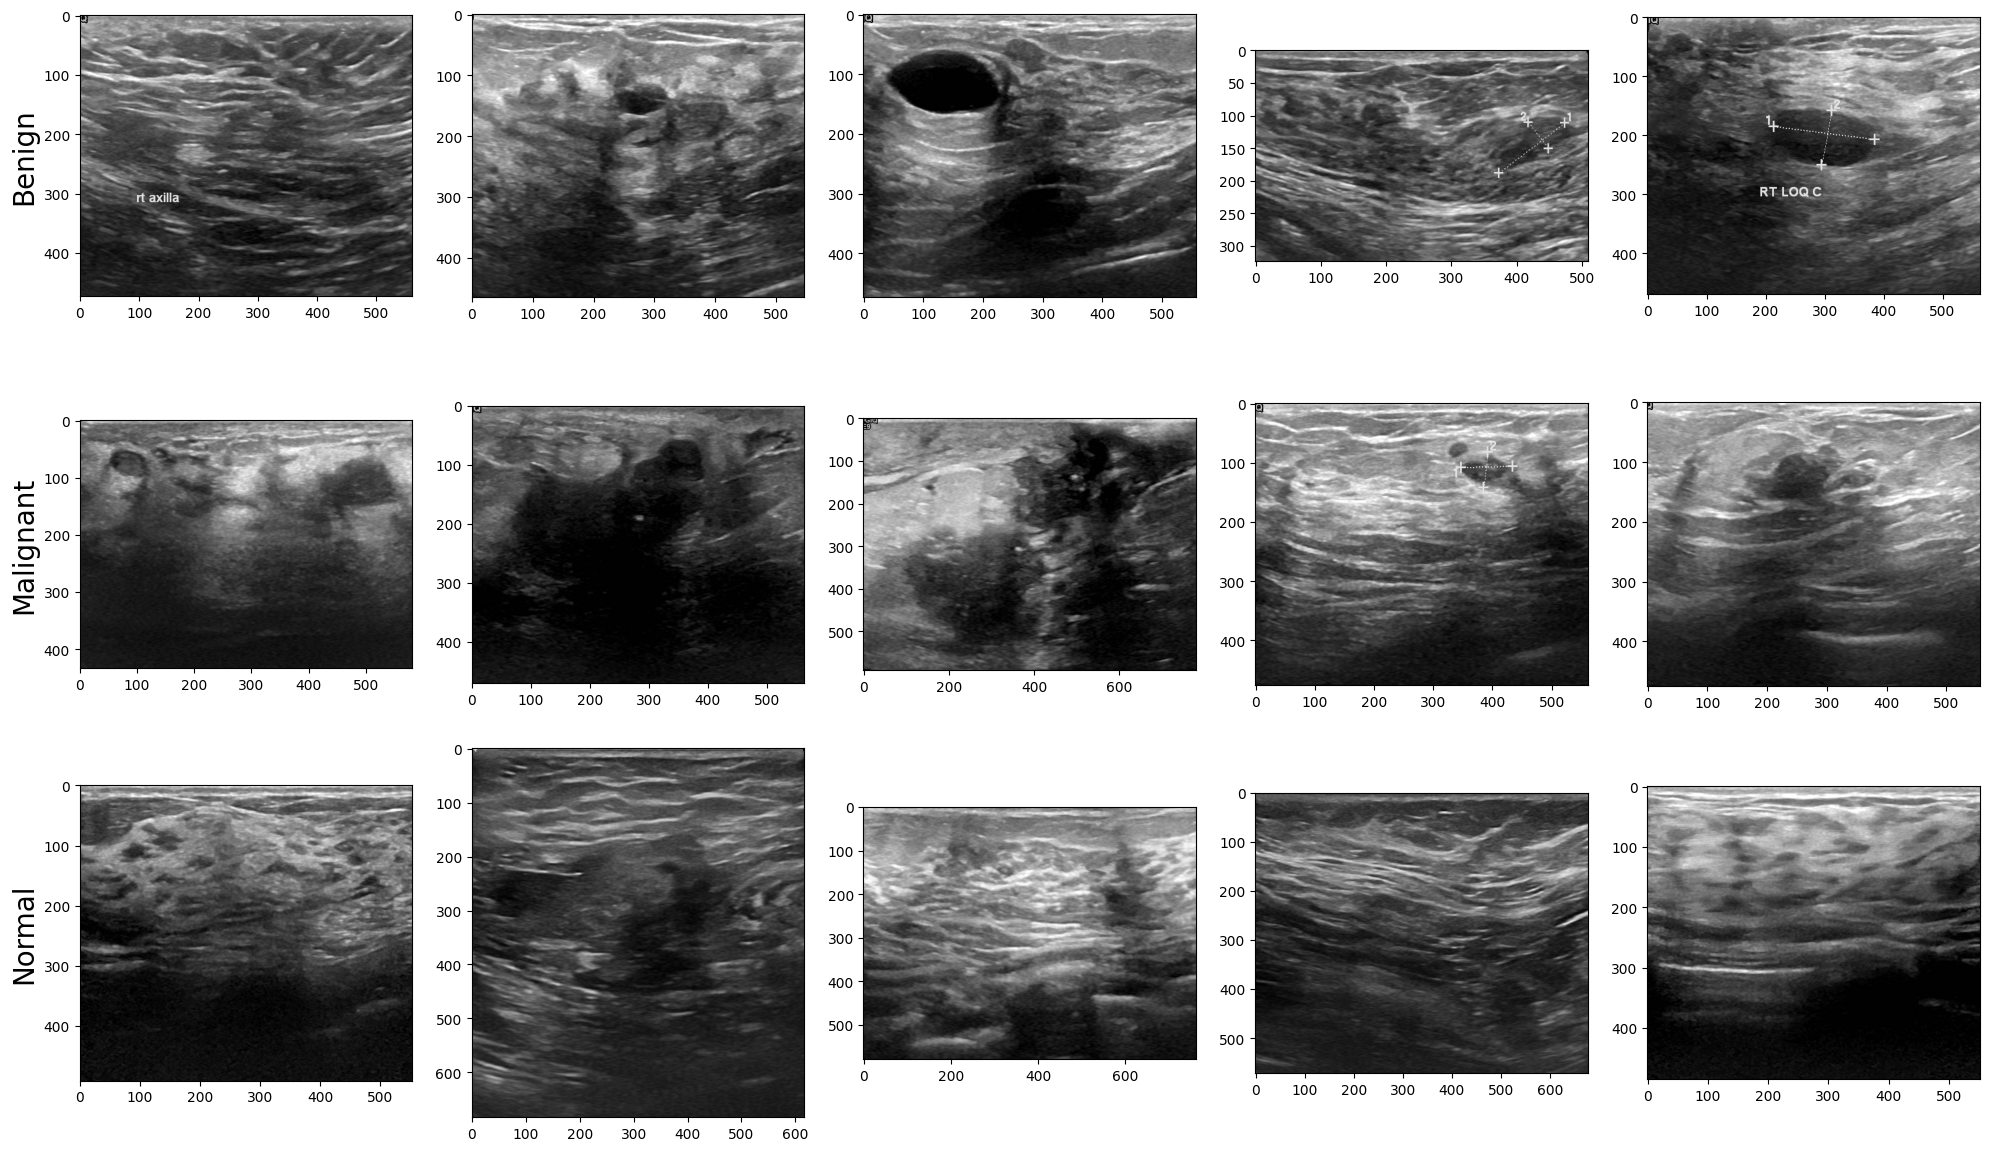

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

for idx, (label, path) in enumerate(directories.items()):
    image_list = display_random_images_from_dir(path)
    
    for i, img in enumerate(image_list):
        axes[idx, i].imshow(img, cmap='gray')
        axes[idx, 0].set_ylabel(label, fontsize=20)

plt.tight_layout()
plt.show()

Some ultrasound images include annotations embedded within the image, which may introduce noise during model training. For optimal results, it would be beneficial to use a curated version of the dataset where such annotations are removed. However, for now, I will proceed with the entire dataset to avoid losing valuable data.

#### Distribution of image sizes

In [9]:
def get_dims(file):
    img = Image.open(file)
    arr = np.array(img)
    h,w,d = arr.shape
    return h,w

def plot_dims(filelist):
    dims = db.from_sequence(filelist).map(get_dims)
    dims = dims.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height', figsize=(4, 2));
    plt.title('Image Sizes (pixels) | {}'.format(n))

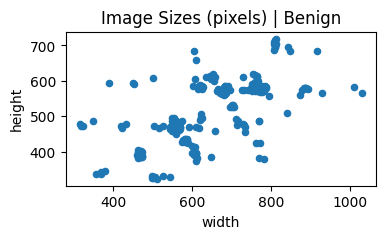

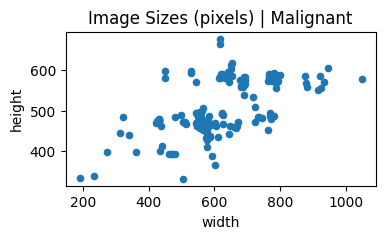

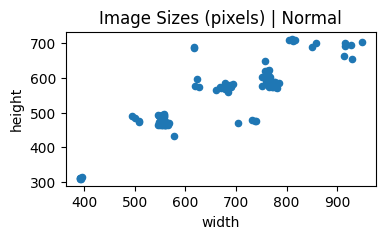

In [10]:
for n,d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    plot_dims(filelist)

As seen earlier in the image samples, image sizes are very variable across the dataset; they will need to be homogenized.

### Dataset splitting

Each class of the dataset will be split into training (80%), validation (10%) and test (10%):

In [11]:
splitfolders.ratio('./data/us_only', output='./data/splitted', seed=42,
                   ratio=(.8, .1, .1), group_prefix=None, move=False)

In [12]:
!tree --filelimit=10 ./data
# tree is a Linux dependency that can be installed with: sudo apt-get install tree

./data
├── full
│   ├── benign  [891 entries exceeds filelimit, not opening dir]
│   ├── malignant  [421 entries exceeds filelimit, not opening dir]
│   └── normal  [266 entries exceeds filelimit, not opening dir]
├── splitted
│   ├── test
│   │   ├── benign  [45 entries exceeds filelimit, not opening dir]
│   │   ├── full
│   │   ├── malignant  [21 entries exceeds filelimit, not opening dir]
│   │   └── normal  [14 entries exceeds filelimit, not opening dir]
│   ├── train
│   │   ├── benign  [349 entries exceeds filelimit, not opening dir]
│   │   ├── full
│   │   ├── malignant  [168 entries exceeds filelimit, not opening dir]
│   │   └── normal  [106 entries exceeds filelimit, not opening dir]
│   └── val
│       ├── benign  [43 entries exceeds filelimit, not opening dir]
│       ├── full
│       ├── malignant  [21 entries exceeds filelimit, not opening dir]
│       └── normal  [13 entries exceeds filelimit, not opening dir]
└── us_only
    ├── benign  [437 entries exceeds filelimit,

In [13]:
dir_train_benign = './data/splitted/train/benign'
dir_train_malignant = './data/splitted/train/malignant'
dir_train_normal = './data/splitted/train/normal'

dir_val_benign = './data/splitted/val/benign'
dir_val_malignant = './data/splitted/val/malignant'
dir_val_normal = './data/splitted/val/normal'

dir_test_benign = './data/splitted/test/benign'
dir_test_malignant = './data/splitted/test/malignant'
dir_test_normal = './data/splitted/test/normal'

#### Loading images

In [14]:
# Images will be homogenously resized to 256x256 pixels:
img_train_benign = image_dataset_from_directory(dir_train_benign, label_mode=None, image_size=(256, 256))
img_train_malignant = image_dataset_from_directory(dir_train_malignant, label_mode=None, image_size=(256, 256))
img_train_normal = image_dataset_from_directory(dir_train_normal, label_mode=None, image_size=(256, 256))

Found 349 files.
Found 168 files.
Found 106 files.


2024-12-09 19:14:37.099922: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
def extract_images_from_dataset(dataset, n_images=5):
    images = []
    for batch in dataset:
        batch_images = batch.numpy()
        images.extend(batch_images)
        if len(images) >= n_images:
            break    
    return images[:n_images]

def display_random_images(images, ax, label):
    for i, img in enumerate(images):
        ax[i].imshow(img.astype('uint8'))
        ax[0].set_ylabel(label, fontsize=20)

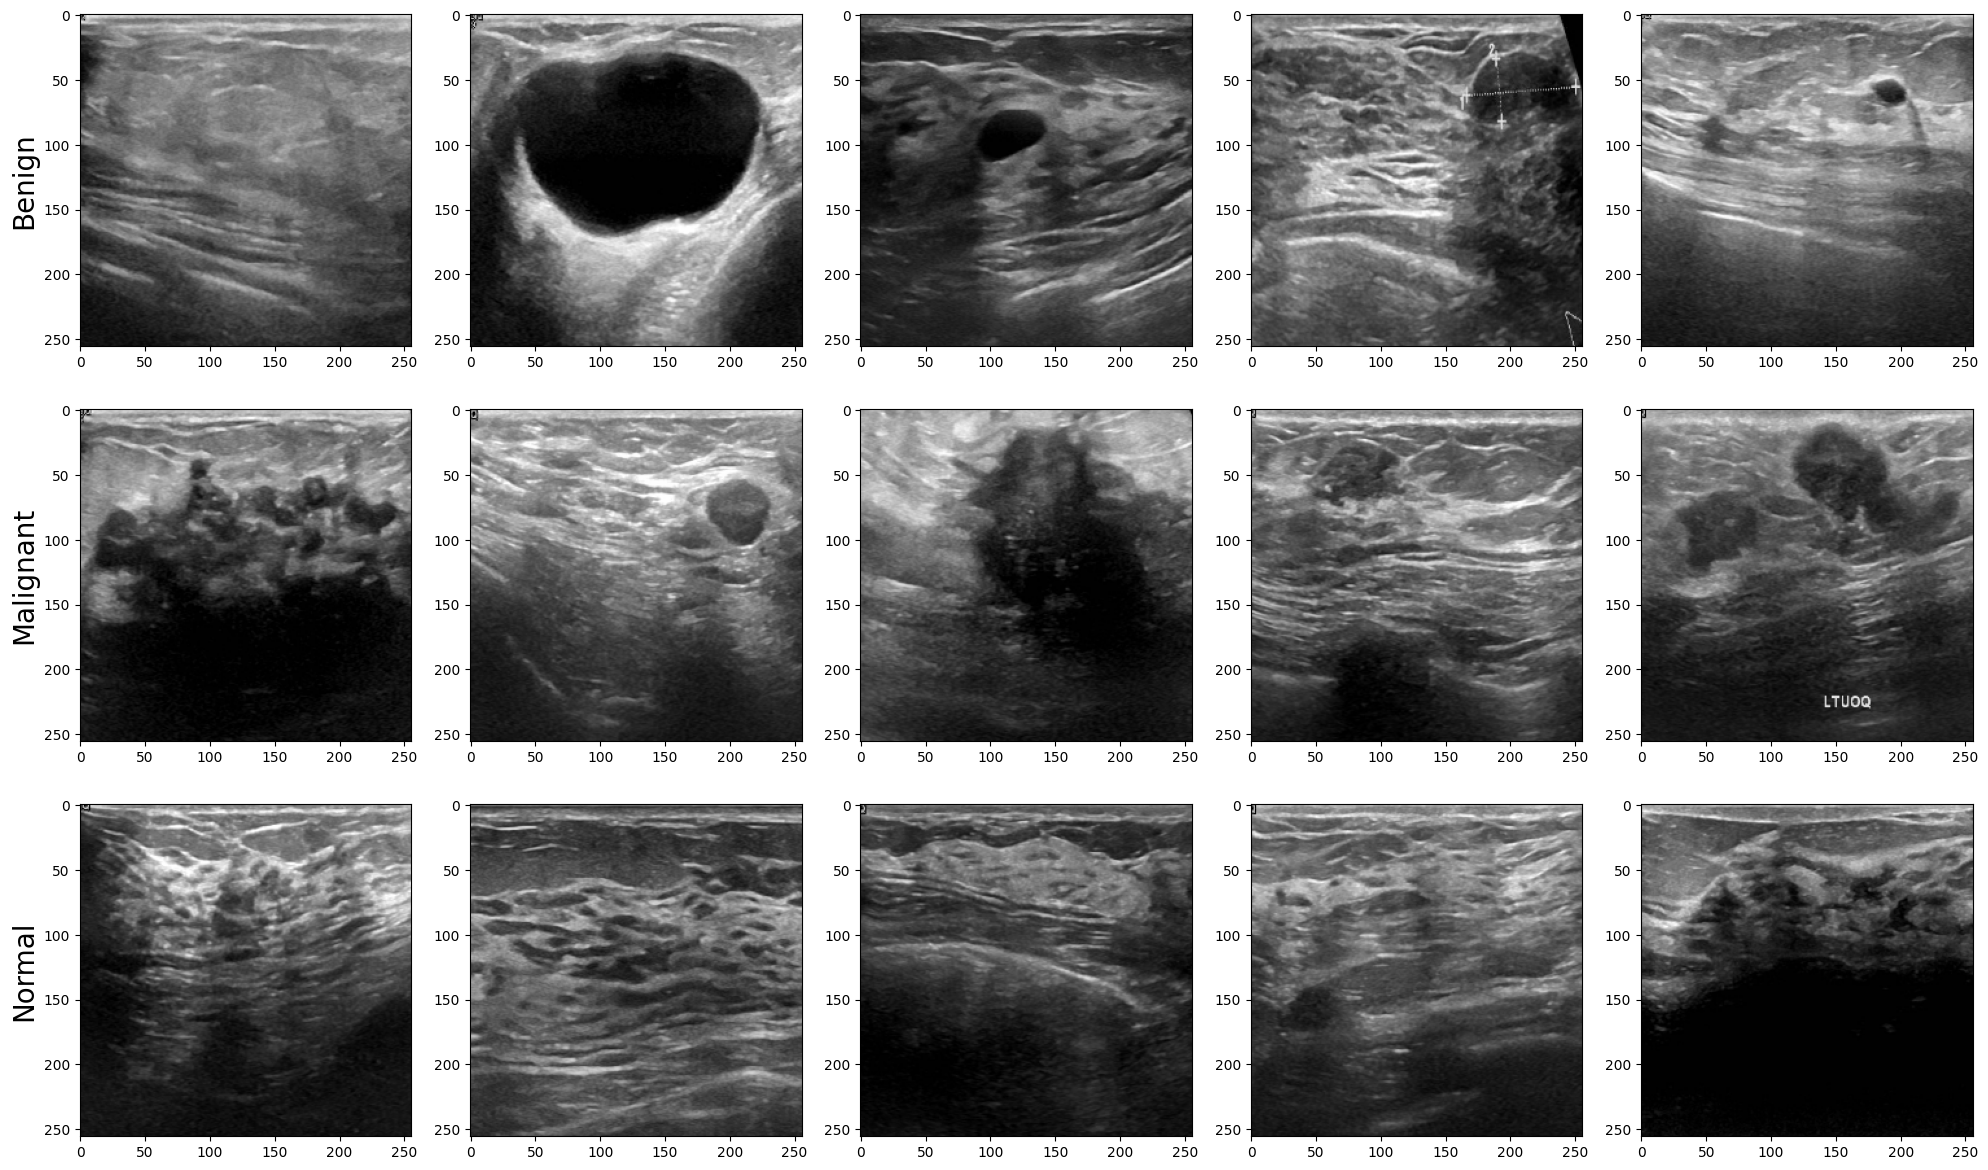

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

# Extract and display 5 random images from each dataset
random_benign_images = extract_images_from_dataset(img_train_benign, n_images=5)
random_malignant_images = extract_images_from_dataset(img_train_malignant, n_images=5)
random_normal_images = extract_images_from_dataset(img_train_normal, n_images=5)

display_random_images(random_benign_images, axes[0], 'Benign')
display_random_images(random_malignant_images, axes[1], 'Malignant')
display_random_images(random_normal_images, axes[2], 'Normal')

plt.tight_layout()
plt.show()

#### Average image

In [17]:
def average_image(images, legend):
    all_img_batch = []
    for img_batch in images:
        img_batch = img_batch.numpy()
        all_img_batch.append(img_batch)
    all_img_batch = np.concatenate(all_img_batch, axis=0)
    mean_img = all_img_batch.mean(axis=0)
    mean_img_show = mean_img / 255
    fig, ax = plt.subplots(figsize=(23, 2))
    ax.imshow(mean_img_show, cmap='gray')
    ax.text(11, 5, legend, bbox={'facecolor': 'white', 'pad': 5})
    plt.show()

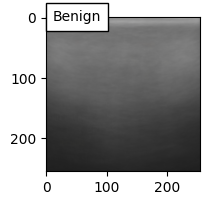

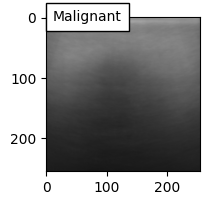

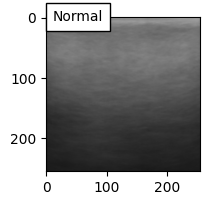

In [21]:
benign_mean = average_image(img_train_benign, 'Benign')
malignant_mean = average_image(img_train_malignant,  'Malignant')
normal_mean = average_image(img_train_normal, 'Normal')

It is impossible to discern any tissue structure in the average images, indicating images within classes are very heterogenous, as seen with the sample images.